# Case study, How does a bike-share navigate speedy success?
<p style="align, center"><img src="./misc/bike.JPG"></p>

## Business Task
Design marketing strategies aimed at converting casual riders into annual members

## Analytic questions:
* How do annual members and casual riders use Cyclistic bikes differently?
* Why would casual riders buy Cyclistic annual memberships? 
* How can Cyclistic use digital media to influence casual riders to become members?

### Source
* 202401-divvy-tripdata.csv
* 202402-divvy-tripdata.csv
* 202403-divvy-tripdata.csv
* 202404-divvy-tripdata.csv
* 202405-divvy-tripdata.csv
* 202406-divvy-tripdata.csv
* 202407-divvy-tripdata.csv
* 202408-divvy-tripdata.csv
* 202409-divvy-tripdata.csv
* 202410-divvy-tripdata.csv
* 202411-divvy-tripdata.csv
* 202412-divvy-tripdata.csv

<p style="font-style: italic;">The data has been made available by Motivate International Inc. under this <a href="https://divvybikes.com/data-license-agreement">license</a>.</p>

## Libraries import

In [113]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta
import geopandas as gpd, geodatasets
from pypalettes import load_cmap
import folium


# Preparation
### Load raw data

In [114]:
csv_files = glob.glob('raw data/*.csv')
dfs = []

for file in csv_files:
    data = pd.read_csv(file, encoding="utf-8",) 
    dfs.append(data)

df = pd.concat(dfs)
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,C1D650626C8C899A,electric_bike,2024-01-12 15:30:27,2024-01-12 15:37:59,Wells St & Elm St,KA1504000135,Kingsbury St & Kinzie St,KA1503000043,41.903267,-87.634737,41.889177,-87.638506,member
1,EECD38BDB25BFCB0,electric_bike,2024-01-08 15:45:46,2024-01-08 15:52:59,Wells St & Elm St,KA1504000135,Kingsbury St & Kinzie St,KA1503000043,41.902937,-87.634440,41.889177,-87.638506,member
2,F4A9CE78061F17F7,electric_bike,2024-01-27 12:27:19,2024-01-27 12:35:19,Wells St & Elm St,KA1504000135,Kingsbury St & Kinzie St,KA1503000043,41.902951,-87.634470,41.889177,-87.638506,member
3,0A0D9E15EE50B171,classic_bike,2024-01-29 16:26:17,2024-01-29 16:56:06,Wells St & Randolph St,TA1305000030,Larrabee St & Webster Ave,13193,41.884295,-87.633963,41.921822,-87.644140,member
4,33FFC9805E3EFF9A,classic_bike,2024-01-31 05:43:23,2024-01-31 06:09:35,Lincoln Ave & Waveland Ave,13253,Kingsbury St & Kinzie St,KA1503000043,41.948797,-87.675278,41.889177,-87.638506,member


### Loading revelant columns

In [115]:
revelant_cols_df = df[['ride_id', 'rideable_type', 'started_at', 'ended_at', 'start_station_name', 'end_station_name', 'member_casual', 'start_lat', 'start_lng', 'end_lat', 'end_lng']].copy()
revelant_cols_df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,end_station_name,member_casual,start_lat,start_lng,end_lat,end_lng
0,C1D650626C8C899A,electric_bike,2024-01-12 15:30:27,2024-01-12 15:37:59,Wells St & Elm St,Kingsbury St & Kinzie St,member,41.903267,-87.634737,41.889177,-87.638506
1,EECD38BDB25BFCB0,electric_bike,2024-01-08 15:45:46,2024-01-08 15:52:59,Wells St & Elm St,Kingsbury St & Kinzie St,member,41.902937,-87.634440,41.889177,-87.638506
2,F4A9CE78061F17F7,electric_bike,2024-01-27 12:27:19,2024-01-27 12:35:19,Wells St & Elm St,Kingsbury St & Kinzie St,member,41.902951,-87.634470,41.889177,-87.638506
3,0A0D9E15EE50B171,classic_bike,2024-01-29 16:26:17,2024-01-29 16:56:06,Wells St & Randolph St,Larrabee St & Webster Ave,member,41.884295,-87.633963,41.921822,-87.644140
4,33FFC9805E3EFF9A,classic_bike,2024-01-31 05:43:23,2024-01-31 06:09:35,Lincoln Ave & Waveland Ave,Kingsbury St & Kinzie St,member,41.948797,-87.675278,41.889177,-87.638506


### Efficient datatypes conversion 

In [116]:
schema = {
    'ride_id': 'string[pyarrow]',
    'rideable_type': 'category',
    'started_at': 'datetime64[ns]',
    'ended_at': 'datetime64[ns]',
    'start_station_name': 'category',
    'end_station_name': 'category',
    'member_casual': 'category',
    'start_lat': 'category', 
    'start_lng': 'category', 
    'end_lat': 'category', 
    'end_lng': 'category'
}

cast_df = revelant_cols_df.astype(schema).copy()
cast_df.dtypes

ride_id               string[pyarrow]
rideable_type                category
started_at             datetime64[ns]
ended_at               datetime64[ns]
start_station_name           category
end_station_name             category
member_casual                category
start_lat                    category
start_lng                    category
end_lat                      category
end_lng                      category
dtype: object

### Memory usage comparison

In [117]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 5860568 entries, 0 to 178371
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   started_at          object 
 3   ended_at            object 
 4   start_station_name  object 
 5   start_station_id    object 
 6   end_station_name    object 
 7   end_station_id      object 
 8   start_lat           float64
 9   start_lng           float64
 10  end_lat             float64
 11  end_lng             float64
 12  member_casual       object 
dtypes: float64(4), object(9)
memory usage: 3.3 GB


In [118]:
cast_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 5860568 entries, 0 to 178371
Data columns (total 11 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             string        
 1   rideable_type       category      
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  category      
 5   end_station_name    category      
 6   member_casual       category      
 7   start_lat           category      
 8   start_lng           category      
 9   end_lat             category      
 10  end_lng             category      
dtypes: category(8), datetime64[ns](2), string(1)
memory usage: 409.7 MB


# Process

## Preliminary data analysis

In [119]:
cast_df.shape

(5860568, 11)

In [120]:
cast_df.head(10)

,ride_id,rideable_type,started_at,ended_at,start_station_name,end_station_name,member_casual,start_lat,start_lng,end_lat,end_lng
0,C1D650626C8C899A,electric_bike,2024-01-12 15:30:27,2024-01-12 15:37:59,Wells St & Elm St,Kingsbury St & Kinzie St,member,41.903267,-87.634737,41.889177,-87.638506
1,EECD38BDB25BFCB0,electric_bike,2024-01-08 15:45:46,2024-01-08 15:52:59,Wells St & Elm St,Kingsbury St & Kinzie St,member,41.902937,-87.634440,41.889177,-87.638506
2,F4A9CE78061F17F7,electric_bike,2024-01-27 12:27:19,2024-01-27 12:35:19,Wells St & Elm St,Kingsbury St & Kinzie St,member,41.902951,-87.634470,41.889177,-87.638506
3,0A0D9E15EE50B171,classic_bike,2024-01-29 16:26:17,2024-01-29 16:56:06,Wells St & Randolph St,Larrabee St & Webster Ave,member,41.884295,-87.633963,41.921822,-87.644140
4,33FFC9805E3EFF9A,classic_bike,2024-01-31 05:43:23,2024-01-31 06:09:35,Lincoln Ave & Waveland Ave,Kingsbury St & Kinzie St,member,41.948797,-87.675278,41.889177,-87.638506
5,C96080812CD285C5,classic_bike,2024-01-07 11:21:24,2024-01-07 11:30:03,Wells St & Elm St,Kingsbury St & Kinzie St,member,41.903222,-87.634324,41.889177,-87.638506
6,0EA7CB313D4F456A,classic_bike,2024-01-05 14:44:12,2024-01-05 14:53:06,Wells St & Elm St,Kingsbury St & Kinzie St,member,41.903222,-87.634324,41.889177,-87.638506
7,EE11F3A3B39CFBD8,electric_bike,2024-01-04 18:19:53,2024-01-04 18:28:04,Wells St & Elm St,Kingsbury St & Kinzie St,member,41.903368,-87.634861,41.889177,-87.638506
8,63E83DE8E3279F15,classic_bike,2024-01-01 14:46:53,2024-01-01 14:57:02,Wells St & Elm St,Kingsbury St & Kinzie St,member,41.903222,-87.634324,41.889177,-87.638506
9,8005682869122D93,electric_bike,2024-01-03 19:31:08,2024-01-03 19:40:05,Clark St & Ida B Wells Dr,Kingsbury St & Kinzie St,member,41.876033,-87.630866,41.889177,-87.638506


In [121]:
cast_df.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'end_station_name', 'member_casual', 'start_lat',
       'start_lng', 'end_lat', 'end_lng'],
      dtype='object')

In [122]:
cast_df.describe()

,started_at,ended_at
count,5860568,5860568
mean,2024-07-17 07:55:47.617262848,2024-07-17 08:13:06.552330496
min,2024-01-01 00:00:39,2024-01-01 00:04:20
25%,2024-05-20 19:47:53,2024-05-20 20:07:54.750000128
50%,2024-07-22 20:36:16.283500032,2024-07-22 20:53:59.158500096
75%,2024-09-17 20:14:22.566249984,2024-09-17 20:27:46.025999872
max,2024-12-31 23:56:49.854000,2024-12-31 23:59:55.705000


## Check for N/A values and duplicates

### Check N/A

In [123]:
cast_df.isna().sum()

ride_id                     0
rideable_type               0
started_at                  0
ended_at                    0
start_station_name    1073951
end_station_name      1104653
member_casual               0
start_lat                   0
start_lng                   0
end_lat                  7232
end_lng                  7232
dtype: int64

### Assuming that rides without registered start or end station are registered by errors thus we won't take them into analysis

In [124]:
clean_df = cast_df.dropna().copy()

### Checking for duplicated with the same ride id

In [125]:
clean_df.loc[clean_df.duplicated(subset=['ride_id'], keep=False)].head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,end_station_name,member_casual,start_lat,start_lng,end_lat,end_lng
943,2C772EDDDBDEFDA3,electric_bike,2024-05-31 23:42:42,2024-06-01 00:25:08,Dearborn St & Van Buren St,DuSable Lake Shore Dr & Monroe St,casual,41.876054,-87.629921,41.880958,-87.616743
17181,7BC67FD33887B3CB,classic_bike,2024-05-31 22:54:20,2024-06-01 00:42:41,Burnham Harbor,St. Louis Ave & Fullerton Ave,casual,41.857412,-87.613792,41.924816,-87.714495
20441,43CD52984AD22D99,electric_bike,2024-05-31 23:45:51,2024-06-01 00:11:46,Wentworth Ave & Cermak Rd*,Loomis St & Lexington St,member,41.853098,-87.631871,41.872229,-87.661364
22451,ABBD88BEBC1431FF,electric_bike,2024-05-31 23:20:35,2024-06-01 00:33:41,McClurg Ct & Erie St,McClurg Ct & Erie St,casual,41.894351,-87.617765,41.894503,-87.617854
25437,CA12CCDD359DA80C,classic_bike,2024-05-31 23:54:35,2024-06-01 00:01:25,Halsted St & Archer Ave,Morgan St & 31st St,casual,41.847203,-87.646795,41.837800,-87.651140


In [126]:
clean_df = clean_df.drop_duplicates(subset=['ride_id']).copy()

### Checking for stations that have same start time, end time, start station and end station

In [127]:
clean_df.loc[clean_df.duplicated(subset=['started_at', 'ended_at', 'start_station_name', 'end_station_name'], keep=False)]

,ride_id,rideable_type,started_at,ended_at,start_station_name,end_station_name,member_casual,start_lat,start_lng,end_lat,end_lng
102692,D3CE8F069C526B23,classic_bike,2024-01-30 20:27:57,2024-01-30 20:50:51,Canal St & Adams St,State St & Randolph St,member,41.879255,-87.639904,41.884621,-87.627834
102754,BD06A0FDAC1D1183,classic_bike,2024-01-30 20:27:57,2024-01-30 20:50:51,Canal St & Adams St,State St & Randolph St,member,41.879255,-87.639904,41.884621,-87.627834
71207,A47F1F8E79A156BC,classic_bike,2024-02-27 13:40:53,2024-02-27 13:57:21,McClurg Ct & Erie St,Halsted St & Clybourn Ave,casual,41.894503,-87.617854,41.909668,-87.648128
165886,36EE4451474A3DC0,classic_bike,2024-02-27 13:40:53,2024-02-27 13:57:21,McClurg Ct & Erie St,Halsted St & Clybourn Ave,casual,41.894503,-87.617854,41.909668,-87.648128


In [128]:
clean_df = clean_df.drop_duplicates(subset=['started_at', 'ended_at', 'start_station_name', 'end_station_name']).copy()

### Checking for stations that have same start time, end time, start station or end station
Whenever those records need to be deleted, consultation with someone from the company is required to determine if the given station can hold more than two bikes.

In [129]:
clean_df.loc[clean_df.duplicated(subset=['started_at', 'ended_at', 'start_station_name'], keep=False)]

,ride_id,rideable_type,started_at,ended_at,start_station_name,end_station_name,member_casual,start_lat,start_lng,end_lat,end_lng


In [130]:
clean_df.loc[clean_df.duplicated(subset=['started_at', 'ended_at', 'end_station_name'], keep=False)]

,ride_id,rideable_type,started_at,ended_at,start_station_name,end_station_name,member_casual,start_lat,start_lng,end_lat,end_lng
102616,48AB680D63B319F5,classic_bike,2024-03-04 17:36:30,2024-03-04 17:46:12,Mies van der Rohe Way & Chestnut St,New St & Illinois St,member,41.898587,-87.621915,41.890847,-87.618617
181898,FAA4EB520E8918AF,classic_bike,2024-03-04 17:36:30,2024-03-04 17:46:12,Wells St & Huron St,New St & Illinois St,member,41.894722,-87.634362,41.890847,-87.618617


### Creating ride_time column that shows difference between ended_at and started_at

In [131]:
ride_time = clean_df['ended_at'] - clean_df['started_at']
clean_df.insert(4, 'ride_time', ride_time)
clean_df.head()

,ride_id,rideable_type,started_at,ended_at,ride_time,start_station_name,end_station_name,member_casual,start_lat,start_lng,end_lat,end_lng
0,C1D650626C8C899A,electric_bike,2024-01-12 15:30:27,2024-01-12 15:37:59,0 days 00:07:32,Wells St & Elm St,Kingsbury St & Kinzie St,member,41.903267,-87.634737,41.889177,-87.638506
1,EECD38BDB25BFCB0,electric_bike,2024-01-08 15:45:46,2024-01-08 15:52:59,0 days 00:07:13,Wells St & Elm St,Kingsbury St & Kinzie St,member,41.902937,-87.634440,41.889177,-87.638506
2,F4A9CE78061F17F7,electric_bike,2024-01-27 12:27:19,2024-01-27 12:35:19,0 days 00:08:00,Wells St & Elm St,Kingsbury St & Kinzie St,member,41.902951,-87.634470,41.889177,-87.638506
3,0A0D9E15EE50B171,classic_bike,2024-01-29 16:26:17,2024-01-29 16:56:06,0 days 00:29:49,Wells St & Randolph St,Larrabee St & Webster Ave,member,41.884295,-87.633963,41.921822,-87.644140
4,33FFC9805E3EFF9A,classic_bike,2024-01-31 05:43:23,2024-01-31 06:09:35,0 days 00:26:12,Lincoln Ave & Waveland Ave,Kingsbury St & Kinzie St,member,41.948797,-87.675278,41.889177,-87.638506


### Checking for rides that lasted less than 10 seconds

In [132]:
clean_df[clean_df['ride_time'] <= timedelta(seconds=10)].head()

,ride_id,rideable_type,started_at,ended_at,ride_time,start_station_name,end_station_name,member_casual,start_lat,start_lng,end_lat,end_lng
3184,C1FF15F72F5E6CB9,classic_bike,2024-01-17 12:43:55,2024-01-17 12:44:02,0 days 00:00:07,Loomis St & Lexington St,Loomis St & Lexington St,member,41.872229,-87.661364,41.872229,-87.661364
3190,5AA3D2E8010FEF7D,classic_bike,2024-01-17 14:25:27,2024-01-17 14:25:29,0 days 00:00:02,Halsted St & Wrightwood Ave,Halsted St & Wrightwood Ave,member,41.929143,-87.649077,41.929143,-87.649077
3196,27E081696A03E872,classic_bike,2024-01-02 10:32:54,2024-01-02 10:32:56,0 days 00:00:02,Halsted St & Wrightwood Ave,Halsted St & Wrightwood Ave,member,41.929143,-87.649077,41.929143,-87.649077
3214,785A6FF31548084A,electric_bike,2024-01-09 12:08:38,2024-01-09 12:08:41,0 days 00:00:03,Public Rack - Walden Pkwy & 103rd St,Public Rack - Walden Pkwy & 103rd St,member,41.706084,-87.669024,41.706205,-87.668965
3888,188E0BD5237F114A,electric_bike,2024-01-13 07:59:43,2024-01-13 07:59:45,0 days 00:00:02,Milwaukee Ave & Grand Ave,Milwaukee Ave & Grand Ave,member,41.891447,-87.648382,41.891578,-87.648384


### Creating sorted dataframe

In [133]:
analysis_df = clean_df[~(clean_df['ride_time'] <= timedelta(seconds=10))].copy()
analysis_df = analysis_df.sort_values('started_at')
analysis_df.head()

,ride_id,rideable_type,started_at,ended_at,ride_time,start_station_name,end_station_name,member_casual,start_lat,start_lng,end_lat,end_lng
48853,56F5C3ED5178C131,classic_bike,2024-01-01 00:01:01,2024-01-01 00:24:12,0 days 00:23:11,LaSalle St & Illinois St,Indiana Ave & Roosevelt Rd,member,41.890762,-87.631697,41.867888,-87.623041
26576,70BDF49A30C8BFFC,classic_bike,2024-01-01 00:02:15,2024-01-01 00:07:01,0 days 00:04:46,Sheffield Ave & Fullerton Ave,Greenview Ave & Fullerton Ave,casual,41.925602,-87.653708,41.925330,-87.665800
46733,B7F1F63BD1AFF4E9,classic_bike,2024-01-01 00:06:59,2024-01-01 00:17:21,0 days 00:10:22,Western Ave & Howard St,Clark St & Lunt Ave,member,42.018901,-87.690048,42.009011,-87.674112
40692,444DD0D82A50BA8C,classic_bike,2024-01-01 00:07:45,2024-01-01 00:15:41,0 days 00:07:56,DuSable Lake Shore Dr & North Blvd,Sedgwick St & Webster Ave,casual,41.911722,-87.626804,41.922167,-87.638888
71103,510C1C0AA564ADF0,classic_bike,2024-01-01 00:07:57,2024-01-01 00:29:42,0 days 00:21:45,Clinton St & Tilden St,LaSalle St & Illinois St,casual,41.875885,-87.640795,41.890762,-87.631697


### Creating month and weekday columns of when rides started

In [134]:
month = analysis_df['started_at'].dt.month
weekday = analysis_df['started_at'].dt.day_name().astype('category')
analysis_df.insert(5, 'month', month)
analysis_df.insert(6, 'weekday', weekday)
analysis_df.head()

,ride_id,rideable_type,started_at,ended_at,ride_time,month,weekday,start_station_name,end_station_name,member_casual,start_lat,start_lng,end_lat,end_lng
48853,56F5C3ED5178C131,classic_bike,2024-01-01 00:01:01,2024-01-01 00:24:12,0 days 00:23:11,1,Monday,LaSalle St & Illinois St,Indiana Ave & Roosevelt Rd,member,41.890762,-87.631697,41.867888,-87.623041
26576,70BDF49A30C8BFFC,classic_bike,2024-01-01 00:02:15,2024-01-01 00:07:01,0 days 00:04:46,1,Monday,Sheffield Ave & Fullerton Ave,Greenview Ave & Fullerton Ave,casual,41.925602,-87.653708,41.925330,-87.665800
46733,B7F1F63BD1AFF4E9,classic_bike,2024-01-01 00:06:59,2024-01-01 00:17:21,0 days 00:10:22,1,Monday,Western Ave & Howard St,Clark St & Lunt Ave,member,42.018901,-87.690048,42.009011,-87.674112
40692,444DD0D82A50BA8C,classic_bike,2024-01-01 00:07:45,2024-01-01 00:15:41,0 days 00:07:56,1,Monday,DuSable Lake Shore Dr & North Blvd,Sedgwick St & Webster Ave,casual,41.911722,-87.626804,41.922167,-87.638888
71103,510C1C0AA564ADF0,classic_bike,2024-01-01 00:07:57,2024-01-01 00:29:42,0 days 00:21:45,1,Monday,Clinton St & Tilden St,LaSalle St & Illinois St,casual,41.875885,-87.640795,41.890762,-87.631697


# Analysis and Share

In [135]:
analysis_df.dtypes

ride_id               string[pyarrow]
rideable_type                category
started_at             datetime64[ns]
ended_at               datetime64[ns]
ride_time             timedelta64[ns]
month                           int32
weekday                      category
start_station_name           category
end_station_name             category
member_casual                category
start_lat                    category
start_lng                    category
end_lat                      category
end_lng                      category
dtype: object

### Checking unique values within columns

In [136]:
analysis_df.nunique()

ride_id               4198335
rideable_type               3
started_at            4077137
ended_at              4079187
ride_time             1512773
month                      12
weekday                     7
start_station_name       1787
end_station_name         1798
member_casual               2
start_lat              428465
start_lng              415170
end_lat                  2329
end_lng                  2330
dtype: int64

### How many users are subscribed and how many are not?

In [137]:
members = (
    analysis_df['member_casual']
    .value_counts()
    .reset_index()
)

members

,member_casual,count
0,member,2680018
1,casual,1518317


In [138]:
members_bar = px.bar(
    members,
    width=1000,
    x='member_casual',
    y='count',
    color='member_casual',
    template='plotly_dark',
    color_discrete_sequence=["goldenrod", "gray"],
)

members_bar.update_layout(
    xaxis_title='Membership status', 
    yaxis_title='User count', 
    title='Users by Subscription',
    showlegend=False,
    xaxis=dict(
        tickvals=members['member_casual'],
        ticktext=['Member', 'Casual']
    )
)

members_bar.show()

### How many users are each using a different rideable devices?

In [139]:
rideable_types = (
    analysis_df['rideable_type']
    .value_counts()
    .reset_index()
)

rideable_types

,rideable_type,count
0,classic_bike,2724476
1,electric_bike,1426242
2,electric_scooter,47617


In [140]:
rideable_types_bar = px.bar(
    rideable_types,
    x='rideable_type',
    y='count',
    color='rideable_type',
    width=1000,
    color_discrete_sequence=['brown', 'dodgerblue', 'lime'],
    template='plotly_dark'
)

rideable_types_bar.update_layout(
    xaxis_title='Transport device', 
    yaxis_title='User count', 
    showlegend=False,
    title='Users by Ridable Device',
        xaxis=dict(
        tickvals=rideable_types['rideable_type'],
        ticktext=['Classic Bike', 'Electric Bike', 'Electric Scooter']
    )
)

rideable_types_bar.show()

### How does the number of users, grouped by subscription type, vary across different weekdays?

In [141]:
cat = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

weekday_count_df = (analysis_df
    .value_counts(['weekday', 'member_casual'])
    .sort_index()
    .reset_index(name='count')
)

weekday_count_df['weekday'] = pd.Categorical(weekday_count_df['weekday'], categories=cat, ordered=True)
weekday_count_df = weekday_count_df.sort_values('weekday')
weekday_count_df.head()

,weekday,member_casual,count
2,Monday,casual,181283
3,Monday,member,398293
10,Tuesday,casual,162472
11,Tuesday,member,420461
12,Wednesday,casual,187000


In [142]:
legend_name = {
    'casual': 'Casual',
    'member': 'Member',
}

weekday_count_bar = px.bar(
    weekday_count_df,
    x='weekday',
    y='count',
    width=1000,
    color='member_casual',
    template='plotly_dark',
    barmode='group',
    color_discrete_sequence=["goldenrod", "gray"],
    category_orders={'member_casual': ['member', 'casual']}
)

weekday_count_bar.update_layout(
    xaxis_title='Weekday', 
    yaxis_title='User count', 
    legend_title_text='Subscription',
    title='Users by Weekday',    
)

weekday_count_bar.for_each_trace(lambda x: x.update(name=legend_name[x.name]))

weekday_count_bar.show()

### What is the monthly trend in user count for each subscription type during 2024?

In [143]:
analysis_df['week_start'] = (analysis_df['started_at'] - pd.to_timedelta(analysis_df['started_at'].dt.weekday, unit='D')).dt.date
analysis_df.head()

,ride_id,rideable_type,started_at,ended_at,ride_time,month,weekday,start_station_name,end_station_name,member_casual,start_lat,start_lng,end_lat,end_lng,week_start
48853,56F5C3ED5178C131,classic_bike,2024-01-01 00:01:01,2024-01-01 00:24:12,0 days 00:23:11,1,Monday,LaSalle St & Illinois St,Indiana Ave & Roosevelt Rd,member,41.890762,-87.631697,41.867888,-87.623041,2024-01-01
26576,70BDF49A30C8BFFC,classic_bike,2024-01-01 00:02:15,2024-01-01 00:07:01,0 days 00:04:46,1,Monday,Sheffield Ave & Fullerton Ave,Greenview Ave & Fullerton Ave,casual,41.925602,-87.653708,41.925330,-87.665800,2024-01-01
46733,B7F1F63BD1AFF4E9,classic_bike,2024-01-01 00:06:59,2024-01-01 00:17:21,0 days 00:10:22,1,Monday,Western Ave & Howard St,Clark St & Lunt Ave,member,42.018901,-87.690048,42.009011,-87.674112,2024-01-01
40692,444DD0D82A50BA8C,classic_bike,2024-01-01 00:07:45,2024-01-01 00:15:41,0 days 00:07:56,1,Monday,DuSable Lake Shore Dr & North Blvd,Sedgwick St & Webster Ave,casual,41.911722,-87.626804,41.922167,-87.638888,2024-01-01
71103,510C1C0AA564ADF0,classic_bike,2024-01-01 00:07:57,2024-01-01 00:29:42,0 days 00:21:45,1,Monday,Clinton St & Tilden St,LaSalle St & Illinois St,casual,41.875885,-87.640795,41.890762,-87.631697,2024-01-01


In [144]:
member_year_count_df = (
    analysis_df
    .value_counts(['week_start', 'member_casual'])
    .sort_index()
    .reset_index(name='count')
)

member_year_count_df.head()

,week_start,member_casual,count
0,2024-01-01,casual,5958
1,2024-01-01,member,25500
2,2024-01-08,casual,3414
3,2024-01-08,member,21431
4,2024-01-15,casual,1726


In [145]:
member_count = member_year_count_df[member_year_count_df['member_casual'] == 'member']['count'].reset_index()['count']
casual_count = member_year_count_df[member_year_count_df['member_casual'] == 'casual']['count'].reset_index()['count']
week_start_index = member_year_count_df[member_year_count_df['member_casual'] == 'member'].reset_index()['week_start']
abs_diff_index = (member_count - casual_count).abs()

gap_df = pd.DataFrame()
gap_df['week_start'] = week_start_index
gap_df['gap_diff'] = abs_diff_index

gap_df.head()

,week_start,gap_diff
0,2024-01-01,19542
1,2024-01-08,18017
2,2024-01-15,9637
3,2024-01-22,17565
4,2024-01-29,25856


In [146]:
legend_name = {
    'casual': 'Casual',
    'member': 'Member',
    'gap_df': 'Gap difference'
}

member_year_line = px.line(
    member_year_count_df,
    x='week_start',
    y='count',
    color='member_casual',
    width=1000,
    template='plotly_dark',
    color_discrete_sequence=['silver', 'goldenrod'],
    
)

member_year_line.add_trace(
    go.Scatter(
        x=gap_df['week_start'],
        y=gap_df['gap_diff'],
        name='gap_df',
        line={
            'dash': 'dash',
            'width': 1
        },
        yaxis="y2"
    )
)

member_year_line.update_layout(
    xaxis_title='Weeks', 
    yaxis_title='User count', 
    title='Users Throughout the 2024 by Subscription Type',
    legend_title_text='Subscription',
    yaxis=dict(
        range=[0, None],
    ),
    yaxis2=dict(
        title=dict(text="Gap difference"),
        dtick=5000,
        tickmode='linear',
        side="right",
        range=[0, None],
        overlaying="y",
        showgrid= False,
    ),
    xaxis=dict(
        dtick="M1",
        tickformat="%b",
    ),
    margin=dict(
        pad=10
    ),
    legend=dict(
        x=1.1
    )
)

member_year_line.for_each_trace(lambda x: x.update(name=legend_name[x.name]))

member_year_line.show()

According to the graph above:
* The number of users with membership is higher then casual users throughout the year by 10,000-30,000.
* Amount of users increase significantly during warmer months peaking between May and September and then decline sharply from October onward.
* The highest user counts for both groups occur during late summer.

### Number of Users throughout the Year by Ride type

In [147]:
ride_year_count_df = (
    analysis_df
    .value_counts(['week_start', 'rideable_type'])
    .sort_index()
    .reset_index(name='count')
)

ride_year_count_df.head()

,week_start,rideable_type,count
0,2024-01-01,classic_bike,19518
1,2024-01-01,electric_bike,11940
2,2024-01-08,classic_bike,15576
3,2024-01-08,electric_bike,9269
4,2024-01-15,classic_bike,10005


In [148]:
legend_name = {
    'classic_bike': 'Classic Bike',
    'electric_bike': 'Electric Bike',
    'electric_scooter': 'Electric Scooter'
}

ride_year_line = px.line(
    ride_year_count_df,
    x='week_start',
    y='count',
    color='rideable_type',
    width=1000,
    template='plotly_dark',
    color_discrete_sequence=['brown', 'dodgerblue', 'lime'],
)

ride_year_line.update_layout(
    xaxis_title='Months', 
    yaxis_title='User count', 
    title='Users Throughout 2024 by Ride',
    legend_title_text='Ride type',
    yaxis=dict(
        range=[0, None],
        dtick=10000,
        side='left'
    ),
    xaxis=dict(
        dtick="M1",
        tickformat="%b",
    ),
    margin=dict(
        pad=10
    ),
)

ride_year_line.for_each_trace(lambda x: x.update(name=legend_name[x.name]))

ride_year_line.show()

According to the graph above:
* There is seasonal trend in usage - users prefer to use classic bikes over electric bikes especially in warmer months
* Electric bikes show more consistent, sustained level throughout the year while classic bikes shows more volatile patterns
* Electric scooters were discontinued after 5 weeks


### Number of Users throughout the Year by Ride type and Subscription
* Electric scooter won't be included in this analisis

In [149]:
bike_ebike_df = analysis_df[(analysis_df['rideable_type'] == 'classic_bike') | (analysis_df['rideable_type'] == 'electric_bike')]
bike_ebike_df.head()

,ride_id,rideable_type,started_at,ended_at,ride_time,month,weekday,start_station_name,end_station_name,member_casual,start_lat,start_lng,end_lat,end_lng,week_start
48853,56F5C3ED5178C131,classic_bike,2024-01-01 00:01:01,2024-01-01 00:24:12,0 days 00:23:11,1,Monday,LaSalle St & Illinois St,Indiana Ave & Roosevelt Rd,member,41.890762,-87.631697,41.867888,-87.623041,2024-01-01
26576,70BDF49A30C8BFFC,classic_bike,2024-01-01 00:02:15,2024-01-01 00:07:01,0 days 00:04:46,1,Monday,Sheffield Ave & Fullerton Ave,Greenview Ave & Fullerton Ave,casual,41.925602,-87.653708,41.925330,-87.665800,2024-01-01
46733,B7F1F63BD1AFF4E9,classic_bike,2024-01-01 00:06:59,2024-01-01 00:17:21,0 days 00:10:22,1,Monday,Western Ave & Howard St,Clark St & Lunt Ave,member,42.018901,-87.690048,42.009011,-87.674112,2024-01-01
40692,444DD0D82A50BA8C,classic_bike,2024-01-01 00:07:45,2024-01-01 00:15:41,0 days 00:07:56,1,Monday,DuSable Lake Shore Dr & North Blvd,Sedgwick St & Webster Ave,casual,41.911722,-87.626804,41.922167,-87.638888,2024-01-01
71103,510C1C0AA564ADF0,classic_bike,2024-01-01 00:07:57,2024-01-01 00:29:42,0 days 00:21:45,1,Monday,Clinton St & Tilden St,LaSalle St & Illinois St,casual,41.875885,-87.640795,41.890762,-87.631697,2024-01-01


In [150]:
ride_member_year_count_df = (
    bike_ebike_df
    .value_counts(['member_casual', 'rideable_type', 'week_start', ])
    .sort_index()
    .reset_index(name='count')
)

ride_member_year_count_df.head()

,member_casual,rideable_type,week_start,count
0,casual,classic_bike,2024-01-01,3252
1,casual,classic_bike,2024-01-08,1855
2,casual,classic_bike,2024-01-15,1137
3,casual,classic_bike,2024-01-22,2435
4,casual,classic_bike,2024-01-29,5396


In [151]:
subscription_rideable_type = ride_member_year_count_df['member_casual'].astype(str) + '_' + ride_member_year_count_df['rideable_type'].astype(str)
ride_member_year_count_df.insert(0, 'subscription_rideable_type', subscription_rideable_type)
ride_member_year_count_df.astype({'subscription_rideable_type': 'category'})

ride_member_year_count_df = ride_member_year_count_df.drop(columns=['member_casual', 'rideable_type'])
ride_member_year_count_df.head()

,subscription_rideable_type,week_start,count
0,casual_classic_bike,2024-01-01,3252
1,casual_classic_bike,2024-01-08,1855
2,casual_classic_bike,2024-01-15,1137
3,casual_classic_bike,2024-01-22,2435
4,casual_classic_bike,2024-01-29,5396


In [152]:
legend_name = {
    'casual_classic_bike': 'Casual Classic Bike',
    'member_classic_bike': 'Member Classic Bike',
    'casual_electric_bike': 'Casual Electric Bike',
    'member_electric_bike': 'Member Electric Bike',
}

ride_bike_year_line = px.line(
    ride_member_year_count_df,
    x='week_start',
    y=['count'],
    color='subscription_rideable_type',
    width=1000,
    template='plotly_dark',
    color_discrete_sequence=[
        'rgb(90, 90, 255)',  # Casual Classic Bike
        'rgb(30, 30, 255)',  # Casual Electric Bike
        'rgb(255, 90, 90)',  # Member Classic Bike
        'rgb(255, 30, 30)',  # Member Electric Bike
    ]
)

ride_bike_year_line.update_layout(
    xaxis_title='Months', 
    yaxis_title='User count', 
    title='Users throughout the Year by Ride and Subscription',
    legend_title_text='Ride type',
    yaxis=dict(
        range=[0, None],
        dtick=10000,
        side='left'
    ),
    xaxis=dict(
        dtick="M1",
        tickformat="%b",
    ),
    margin=dict(
        pad=10
    ),
)

ride_bike_year_line.for_each_trace(lambda x: x.update(name=legend_name[x.name]))

ride_bike_year_line.show()

According to the graph above:
* No additional trends have been noticed compared to the last graphs.

### Number of Users by Stations

In [153]:
station_df = (
    analysis_df
    .value_counts(['start_station_name'])
    .reset_index()
)

most_popular_stations_df = station_df.head(20)
most_popular_stations_df.head(5)

,start_station_name,count
0,Streeter Dr & Grand Ave,62148
1,DuSable Lake Shore Dr & Monroe St,41385
2,DuSable Lake Shore Dr & North Blvd,36587
3,Michigan Ave & Oak St,36263
4,Kingsbury St & Kinzie St,35771


In [154]:
most_popular_stations = most_popular_stations_df['start_station_name'].reset_index(drop=True).to_list()

most_popular_stations_df = (
    analysis_df
    .query('start_station_name in @most_popular_stations')
    .value_counts(['start_station_name', 'member_casual'])
    .reset_index()
)

most_popular_stations_df['start_station_name'] = pd.Categorical(most_popular_stations_df['start_station_name'], categories=most_popular_stations, ordered=True)
most_popular_stations_df = most_popular_stations_df.sort_values('start_station_name').reset_index(drop=True)

most_popular_stations_df.head(10)

,start_station_name,member_casual,count
0,Streeter Dr & Grand Ave,casual,48223
1,Streeter Dr & Grand Ave,member,13925
2,DuSable Lake Shore Dr & Monroe St,casual,32115
3,DuSable Lake Shore Dr & Monroe St,member,9270
4,DuSable Lake Shore Dr & North Blvd,casual,21326
5,DuSable Lake Shore Dr & North Blvd,member,15261
6,Michigan Ave & Oak St,casual,23269
7,Michigan Ave & Oak St,member,12994
8,Kingsbury St & Kinzie St,member,26749
9,Kingsbury St & Kinzie St,casual,9022


In [155]:
legend_name = {
    'casual': 'Casual',
    'member': 'Member',
}

most_popular_stations_records_bar = px.bar(
    most_popular_stations_df,
    x='start_station_name',
    y='count',
    color='member_casual',
    width=1400,
    template='plotly_dark',
    color_discrete_sequence=['silver', 'goldenrod'],
)

most_popular_stations_records_bar.for_each_trace(lambda x: x.update(name=legend_name[x.name]))

most_popular_stations_records_bar.update_layout(
    xaxis_title='Station name', 
    yaxis_title='Activity', 
    title='Users by Most Popular Stations',
    legend_title_text='Subscription',
    yaxis=dict(
        range=[0, None],
        dtick=10000,
        side='left'
    ),
    xaxis=dict(
        dtick="M1",
        tickformat="%b",
    ),
    margin=dict(
        pad=10
    ),
)

most_popular_stations_records_bar.show()

According to the graph above:
* Streeter Dr & Grand Ave stands out as the highest used stations with dominant casual users.
* Variation in usage patterns across station indicates different roles - some for commute (members) and some for tourist spots (casual)

### Most popular stations by casual users

In [156]:
station_member_df = (
    analysis_df
    .value_counts(['start_station_name', 'member_casual'])
    .reset_index()
)

station_member_pivot = (
    station_member_df
    .pivot(index='start_station_name', columns='member_casual', values='count')
)

casual_dominant_stations = (
    station_member_pivot
    .query('casual > member')
    .head(20)
    .index
    .tolist()
)

casual_dominant_stations

['Streeter Dr & Grand Ave',
 'DuSable Lake Shore Dr & Monroe St',
 'Michigan Ave & Oak St',
 'DuSable Lake Shore Dr & North Blvd',
 'Millennium Park',
 'Shedd Aquarium',
 'Dusable Harbor',
 'Theater on the Lake',
 'Michigan Ave & 8th St',
 'Adler Planetarium',
 'Buckingham Fountain',
 'Montrose Harbor',
 'Field Museum',
 'Lincoln Park Conservatory',
 'Michigan Ave & Jackson Blvd',
 'McCormick Place',
 'Streeter Dr/Grand Ave',
 'Michigan Ave & Pearson St',
 'Michigan Ave & Ida B Wells Dr',
 'Lakefront Trail & Wilson Ave']

In [157]:
most_popular_casual_stations_df = (
    analysis_df
    .query('start_station_name in @casual_dominant_stations')
    .value_counts(['start_station_name', 'member_casual'])
    .reset_index()
)

most_popular_casual_stations_df.head(10)

,start_station_name,member_casual,count
0,Streeter Dr & Grand Ave,casual,48223
1,DuSable Lake Shore Dr & Monroe St,casual,32115
2,Michigan Ave & Oak St,casual,23269
3,DuSable Lake Shore Dr & North Blvd,casual,21326
4,Millennium Park,casual,20803
5,Shedd Aquarium,casual,20078
6,Dusable Harbor,casual,17246
7,Theater on the Lake,casual,15377
8,DuSable Lake Shore Dr & North Blvd,member,15261
9,Streeter Dr & Grand Ave,member,13925


In [158]:
legend_name = {
    'casual': 'Casual',
    'member': 'Member',
}

most_popular_stations_records_bar = px.bar(
    most_popular_casual_stations_df,
    x='start_station_name',
    y='count',
    color='member_casual',
    width=1400,
    template='plotly_dark',
    color_discrete_sequence=['silver', 'goldenrod'],
)

most_popular_stations_records_bar.for_each_trace(lambda x: x.update(name=legend_name[x.name]))

most_popular_stations_records_bar.update_layout(
    xaxis_title='Station name', 
    yaxis_title='Activity', 
    title='Users by Most Popular Stations for Casual Users',
    legend_title_text='Subscription',
    yaxis=dict(
        range=[0, None],
        dtick=10000,
        side='left'
    ),
    xaxis=dict(
        dtick="M1",
        tickformat="%b",
    ),
    margin=dict(
        pad=10
    ),
)

most_popular_stations_records_bar.show()

According to the graph above:
* High casual use at stations near attractions or scenic areas confirms that casual riders are likely tourists or occasional users

### Number of Users by Geolocation

In [159]:
geo_member_df = (
    analysis_df
    .value_counts(['start_lat', 'start_lng'])
    .reset_index()
    .query('count > 100')
    .astype({'start_lat': 'float64', 'start_lng': 'float64',})
)

geo_member_df

,start_lat,start_lng,count
0,41.892278,-87.612043,55900
1,41.880958,-87.616743,37223
2,41.911722,-87.626804,33175
3,41.900960,-87.623777,31666
4,41.889177,-87.638506,29669
...,...,...,...
749,41.930980,-87.801060,102
750,41.902820,-87.692397,102
751,41.704575,-87.528232,102
752,41.924751,-87.778272,102


In [160]:
geo_member_scatter_map = px.scatter_map(
    geo_member_df,
    lat='start_lat',
    lon='start_lng',
    size='count',
    color='count',
    size_max=15, 
    zoom=10.5,
    width=800,
    height=1000
)

geo_member_scatter_map.show()

In [164]:
commareas = gpd.read_file("chicago-community-areas.geojson")
chicago_areas = commareas[['community', 'geometry']]
chicago_areas

,community,geometry
0,DOUGLAS,"MULTIPOLYGON (((-87.60914 41.84469, -87.60915 ..."
1,OAKLAND,"MULTIPOLYGON (((-87.59215 41.81693, -87.59231 ..."
2,FULLER PARK,"MULTIPOLYGON (((-87.6288 41.80189, -87.62879 4..."
3,GRAND BOULEVARD,"MULTIPOLYGON (((-87.60671 41.81681, -87.6067 4..."
4,KENWOOD,"MULTIPOLYGON (((-87.59215 41.81693, -87.59215 ..."
...,...,...
72,MOUNT GREENWOOD,"MULTIPOLYGON (((-87.69646 41.70714, -87.69644 ..."
73,MORGAN PARK,"MULTIPOLYGON (((-87.64215 41.68508, -87.64249 ..."
74,OHARE,"MULTIPOLYGON (((-87.83658 41.9864, -87.83658 4..."
75,EDGEWATER,"MULTIPOLYGON (((-87.65456 41.99817, -87.65456 ..."


matplotlib.axes._axes.Axes

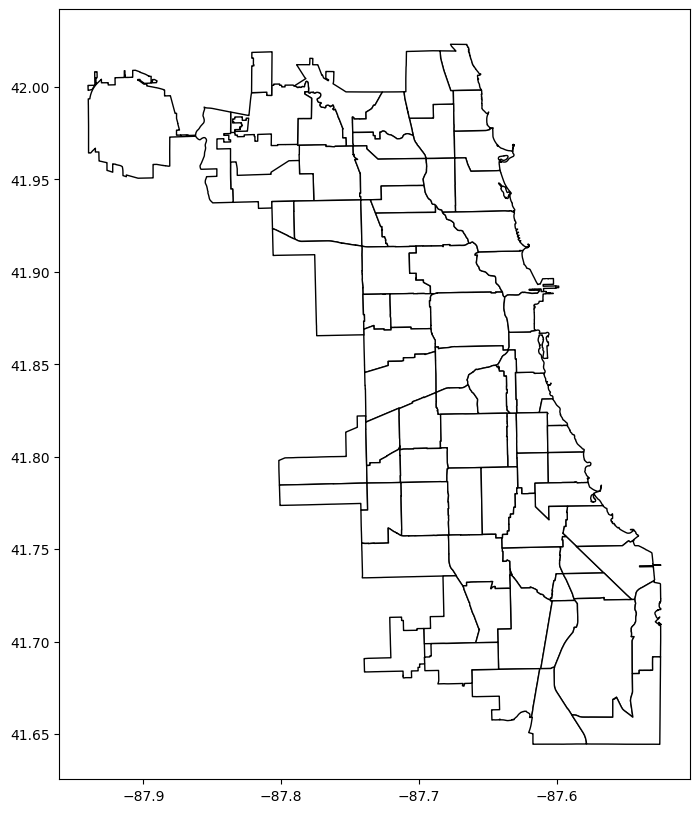

In [177]:
# https://geopandas.org/en/stable/docs/user_guide/mapping.html

# how to assign count values to communities of chicago_areas?
# how to draw scatterplot on base?
# how to do it in plotly?

base = chicago_areas.plot(
    color='white', 
    edgecolor='black', 
    figsize=(15, 10), 
)

type(base)